In [670]:
import matplotlib.pyplot as plt 
import numpy as np 
import hashlib 

In [1007]:
def legendre_symbol(a, p):
  return pow(a, (p - 1) // 2, p)

def tonelli(n, p): 
  q = p - 1
  s = 0 
  while q % 2 == 0: 
    q //= 2 
    s += 1 
  if s == 1: 
    return pow(n, (p+1) // 4, p)
  for z in range(2, p): 
    if p-1 == legendre_symbol(z, p): 
      break 
  c = pow(z, q, p) 
  r = pow(n, (q+1) // 2, p) 
  t = pow(n, q, p)
  m = s 
  t2 = 0 

  while (t-1) % p != 0: 
    t2 = (t*t) % p 
    for i in range(1, m): 
      if (t2 - 1) % p == 0: 
        break 
      t2 = (t2 * t2) % p 
    b = pow(c, 1 << (m - i - 1), p)
    r = (r * b) % p 
    c = (b * b) % p 
    t = (t * c) % p 
    m = i 
  return r 

In [1008]:
def quadratic_residues(p): 
  y = list() 
  for i in range(p): 
    y.append(i**2 % p)
  return set(y)

In [1009]:
def double(x, y, a, p):
  lambd = (((3 * x**2) % p ) *  pow(2 * y, -1, p)) % p
  newx = (lambd**2 - 2 * x) % p
  newy = (-lambd * newx + lambd * x - y) % p
  return (newx, newy)

def add_points(xq, yq, xp, yp, p, a, b):
  if xq == yq == None:
    return xp, yp
  if xp == yp == None:
    return xq, yq

  assert (xq**3 + b) % p == (yq ** 2) % p, "q not on curve"
  assert (xp**3 + b) % p == (yp ** 2) % p, "p not on curve"

  if xq == xp and yq == yp:
    return double(xq, yq, a, p)
  elif xq == xp:
    return None, None

  lambd = ((yq - yp) * pow((xq - xp), -1, p) ) % p
  xr = (lambd**2 - xp - xq) % p
  yr = (lambd*(xp - xr) - yp) % p
  return xr, yr


def count_points_on_curve(a, b, p):
    """Count the number of points on the elliptic curve y^2 = x^3 + ax + b over F_p."""
    if p < 2 or pow(4 * a**3 + 27 * b**2, 1, p) == 0:  # Check if curve is singular
        raise ValueError("Invalid curve: singular or p too small.")
    
    points = 1  # Include the point at infinity
    for x in range(p):
        # Compute y^2 = x^3 + ax + b mod p
        y_squared = (x**3 + a * x + b) % p
        if legendre_symbol(y_squared, p) == 1:
            # If y^2 is a quadratic residue, there are two points (x, y), (x, -y) unless y = 0
            if y_squared == 0:
                points += 1
            else:
                points += 2
    return points

def mod_inverse(a, p):
    """Compute the modular inverse of a modulo p using the extended Euclidean algorithm."""
    if a == 0:
        return None  # No inverse exists
    def extended_gcd(a, b):
        if a == 0:
            return b, 0, 1
        gcd, x1, y1 = extended_gcd(b % a, a)
        x = y1 - (b // a) * x1
        y = x1
        return gcd, x, y
    
    gcd, x, _ = extended_gcd(a, p)
    if gcd != 1:
        return None  # No inverse exists
    return (x % p + p) % p

In [1010]:
count_points_on_curve(a, b, 5393)

5393

In [1011]:
# y^2 = x^3 + a*x + b mod p 

a = 0
b = 7
p = 43 #5393

# x = np.arange(count_points_on_curve(a, b, p))

In [1012]:
assert 0 > (-16 * (4 * a**3 + 27 * b**2)), "not negative"

coords = list()
qr = quadratic_residues(p)
print(qr)
for i in range(p): 
  out = (i**3 + a*i + b) % p
  if out in qr: 
    if out != 0: 
      sq_root = tonelli(out, p)
    else: 
      sq_root = 0 
    coords.append([i, sq_root])
    coords.append([i, p - sq_root])

{0, 1, 4, 6, 9, 10, 11, 13, 14, 15, 16, 17, 21, 23, 24, 25, 31, 35, 36, 38, 40, 41}


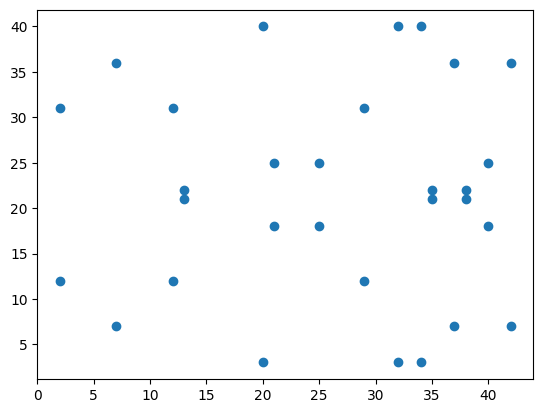

In [1013]:
plt.scatter(np.asarray(coords)[:, 0], np.asarray(coords)[:, 1])

In [1014]:
len(coords), coords[11]

(30, [21, 18])

In [1015]:
next_x, next_y = coords[0][0], coords[0][1]
points = [(next_x, next_y)]

for i in range(1, p+2): 
  next_x, next_y = add_points(next_x, next_y, coords[0][0], coords[0][1], p, a, b)
  points.append((next_x, next_y))

In [1016]:
len(set(points))

31

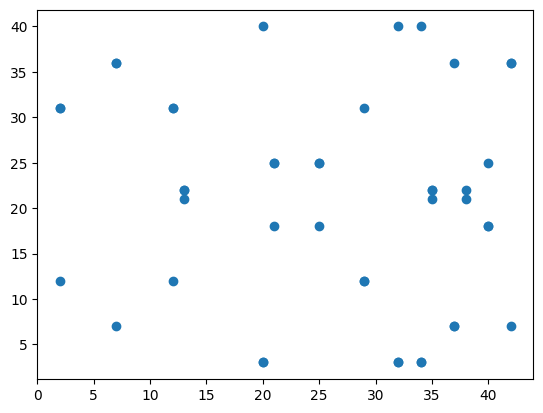

In [1017]:
plt.scatter(np.asarray(points)[:, 0], np.asarray(points)[:, 1])

In [1048]:
### Lets make a private and public key 
print(f'elliptic curve eqn: y^2 = x^3 + {a}*x + {b} (mod {p})')

G = (coords[0][0], coords[0][1])
n = len(set(points)) #count_points_on_curve(a, b, p) # using Hesse's Theorem 
h = 1 

next_x, next_y = None, None 

while next_x == None or next_y == None: 
  d = np.random.randint(1, n-1)
  next_x, next_y = G[0], G[1]
  for i in range(d-1): 
    next_x, next_y = add_points(next_x, next_y, G[0], G[1], p, a, b)

  if next_x == None or next_y == None: 
    next_x, next_y = G[0], G[1]

print(f'private key (d): {d}')
print(f'public key: ({next_x}, {next_y})') 
# private_key = (next_x**3 + a * next_x + b) % p 
# print(f'public key: {private_key}')

elliptic curve eqn: y^2 = x^3 + 0*x + 7 (mod 43)
private key (d): 26
public key: (12, 12)


In [1049]:
m = b"Dudu Tech"
e = int.from_bytes(hashlib.sha256(m).digest(), byteorder='big') % n

r = 0
s = 0 
while r == 0 or s == 0 or r == None or s == None: 
  k = np.random.randint(1, n-1)
  n_x, n_y = G[0], G[1]

  # k.G 
  for i in range(k-1): 
    n_x, n_y = add_points(n_x, n_y, G[0], G[1], p, a, b)

  r = n_x % n 

  # if r == 0: continue

  # s = (mod_inverse(k, n) * ((e)%n + (d*r)%n)) % n
  s = (pow(k, -1, n) * ((e)%n + (d*r)%n)) % n
  # if s == 0: continue 

print(r, s)

12 27


In [1050]:
Q = (next_x, next_y) # public key

# w = mod_inverse(s, n)
w = pow(s, -1, n)

u1 = (e * w) % n
u2 = (r * w) % n

u1Gx, u1Gy = G[0], G[1]
for _ in range(u1-1): 
  u1Gx, u1Gy = add_points(u1Gx, u1Gy, G[0], G[1], p, a, b)

u2Qx, u2Qy = Q[0], Q[1]
for _ in range(u2-1): 
  u2Qx, u2Qy = add_points(u2Qx, u2Qy, Q[0], Q[1], p, a, b)

x_v, y_v = add_points(u1Gx, u1Gy, u2Qx, u2Qy, p, a, b)

v = x_v % n

v == r, v, r

(True, 12, 12)